### Установка необходимых библиотек

### Подключение необходимых библиотек

In [2]:
import os
import sys
import cv2
import h5py
import time
import os.path
import aacgmv2
import glob as gl
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from ellipse import LsqEllipse
import geopy.distance
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

### Вспомогательные функции

In [15]:
DEBUG = False
IONOSPHERIC_HEIGHT = 300
EARTHS_RADIUS = 6371.228
MIN_LAT = 50.0

# шаг сетки, градусы
RESOLUTION = 0.1
# размер маски для определения пограничных точек, градусы
MASK_WIDTH = 1.0
# размер ядра свертки для обогащения данных
DILATE_KERNEL_SIZE = 7
DILATE_ITERATIONS = 10
# ширина и высота эллипса для пространственного объединения бинаризованных данных
CLOSE_WIDTH = 300
CLOSE_HEIGHT = 100

PARAM_FILE_PATH = 'parameters.csv'


def kmeans(X):
    model = KMeans(n_clusters=2).fit(X.reshape(-1, 1))
    threshold = (model.cluster_centers_[0][0]+model.cluster_centers_[1][0])/2
    return threshold


def otsu(X):
    weight = 1.0/len(X)

    y, x = np.histogram(X)

    x = x[:-1]

    threshold = -1000

    max_value = -1

    for i in range(1,len(x)-1):
        pcb = np.sum(y[:i])
        pcf = np.sum(y[i:])
        Wb = pcb * weight
        Wf = pcf * weight
        mub = np.sum(x[:i]*y[:i]) / float(pcb)
        muf = np.sum(x[i:]*y[i:]) / float(pcf)
        value = Wb * Wf * (mub - muf)**2

        if value > max_value:
            threshold = x[i]
            max_value = value

    return threshold


def median(X):
    threshold = np.median(X)
    
    return threshold


def quantile(X, level):
    X_min = X.min()
    X_max = X.max()
    bins = 20
    width = (X_max - X_min) / bins

    y, x = np.histogram(X, range=(X_min, X_max), bins=bins, density=True)
    summa = 0
    for i in range(len(y)):
        summa += y[i]*width
        if summa > level:
            return x[i]

    return 0


def binarize(X, threshold):
    Y = np.zeros(X.shape)
    Y[X >= threshold] = 1

    return Y


def make_ellipse_points(center, width, height, phi):
    t = np.linspace(0, 2*np.pi, 1000)
    ellipse_x = center[0] + width*np.cos(t)*np.cos(phi) - height*np.sin(t)*np.sin(phi)
    ellipse_y = center[1] + width*np.cos(t)*np.sin(phi) + height*np.sin(t)*np.cos(phi)

    ellipse_x = np.append(ellipse_x, ellipse_x[0])
    ellipse_y = np.append(ellipse_y, ellipse_y[0])

    return ellipse_x, ellipse_y


def to_lat_lon(x, y, projection):
    lon_lat = ccrs.Geodetic().transform_point(x, y, projection)
    return lon_lat[1], lon_lat[0]


def get_border_points(time, lats, lons, rotis, threshold, border_type='outer'):
    lats, lons, rotis = convert_latlon(lats, lons, height=IONOSPHERIC_HEIGHT, time=time, values=rotis, method_code='G2A')
    lons_lats = list(zip(lons, lats))
    lons_range = np.arange(-180.0, 180.0-RESOLUTION, RESOLUTION)
    lats_range = np.arange(-90.0, 90.0, RESOLUTION)
    lons_matrix, lats_matrix = np.meshgrid(lons_range, lats_range)

    rotis_matrix = np.zeros(lats_matrix.shape)
    for i in range(len(lons_lats)):
        lon, lat = lons_lats[i]
        x = np.argmin(np.abs(lons_range - lon))
        y = np.argmin(np.abs(lats_range - lat))
        rotis_matrix[y][x] = rotis[i]
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(rotis_matrix, interpolation='none', cmap='gray')
        plt.show()

    # данные ниже определенной широты
    min_id = int((MIN_LAT + 90.0) / RESOLUTION)
    rotis_matrix[:min_id,:] = np.zeros((min_id, rotis_matrix.shape[1]))
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(rotis_matrix, interpolation='none', cmap='gray')
        plt.show()

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (DILATE_KERNEL_SIZE, DILATE_KERNEL_SIZE))
    rotis_matrix_aug = cv2.dilate(rotis_matrix, kernel, iterations=DILATE_ITERATIONS)
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(rotis_matrix_aug, interpolation='none', cmap='gray')
        plt.show()

    ret, bin_matrix = cv2.threshold(rotis_matrix_aug, threshold, 1, cv2.THRESH_BINARY)
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(bin_matrix, interpolation='none', cmap='binary')
        plt.show()

    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (CLOSE_WIDTH, CLOSE_HEIGHT))
    bin_matrix_aug = cv2.morphologyEx(bin_matrix, cv2.MORPH_CLOSE, close_kernel)
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(bin_matrix, interpolation='bilinear', cmap='binary')
        plt.show()

    mask_1, mask_2, L = get_mask_and_level(RESOLUTION, MASK_WIDTH)

    if border_type == 'outer':
        mask_upper = mask_2
        mask_lower = mask_1
    else:
        mask_upper = mask_1
        mask_lower = mask_2

    borders_upper = cv2.filter2D(bin_matrix_aug, -1, mask_upper, borderType=cv2.BORDER_CONSTANT)
    _, borders_upper = cv2.threshold(borders_upper, L, 1, cv2.THRESH_BINARY)
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(borders_upper, interpolation='bilinear', cmap='binary')
        plt.show()

    bin_matrix_inv = 1 - bin_matrix_aug
    borders_lower = cv2.filter2D(bin_matrix_inv, -1, mask_lower, borderType=cv2.BORDER_CONSTANT)
    _, borders_lower = cv2.threshold(borders_lower, L, 1, cv2.THRESH_BINARY)
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(borders_lower, interpolation='bilinear', cmap='binary')
        plt.show()

    borders = (borders_upper * borders_lower).astype(dtype=np.int8)
    if DEBUG == True:
        fig = plt.figure(figsize=(9, 9))
        plt.imshow(borders, interpolation='bilinear', cmap='binary')
        plt.show()
        plt.close()

    border_lats = []
    border_lons = []
    for y in range(borders.shape[0]):
        for x in range(borders.shape[1]):
            if borders[y, x] == 1:
                border_lats.append(lats_matrix[y, x])
                border_lons.append(lons_matrix[y, x])

    border_lats = np.array(border_lats)
    border_lons = np.array(border_lons)
    border_lats, border_lons, _ = convert_latlon(border_lats, border_lons, height=IONOSPHERIC_HEIGHT, time=time, method_code='A2G')

    return border_lats, border_lons


def get_ellipse_parameters(border_lats, border_lons):
    border_lons_lats = np.array(list(zip(border_lons.tolist(), border_lats.tolist())))
    globe = ccrs.Globe(ellipse=None, semimajor_axis=EARTHS_RADIUS*1000, semiminor_axis=EARTHS_RADIUS*1000)
    projection = ccrs.LambertAzimuthalEqualArea(central_latitude=90, central_longitude= -90, globe=globe)

    border_xy = projection.transform_points(ccrs.Geodetic(), border_lons.flatten(), border_lats.flatten())[:,:2]
    border_x = border_xy[:, 0]
    border_y = border_xy[:, 1]

    model = LsqEllipse().fit(border_xy)
    center, width, height, phi = model.as_parameters()
    ellipse_x, ellipse_y = make_ellipse_points(center, width, height, phi)

    ellipse_lons_lats = ccrs.Geodetic().transform_points(projection, ellipse_x.flatten(), ellipse_y.flatten())
    ellipse_lats = ellipse_lons_lats[:,1]
    ellipse_lons = ellipse_lons_lats[:,0]

    ellipse_center_lon_lat = ccrs.Geodetic().transform_point(center[0], center[1], projection)
    ellipse_center_lat = ellipse_center_lon_lat[1]
    ellipse_center_lon = ellipse_center_lon_lat[0]

    ellipse_width_x = center[0] + width*np.cos(phi)
    ellipse_width_y = center[1] + width*np.sin(phi)
    ellipse_width_lat, ellipse_width_lon = to_lat_lon(ellipse_width_x, ellipse_width_y, projection)

    t = np.pi / 2
    ellipse_height_x = center[0] + width*np.cos(t)*np.cos(phi) - height*np.sin(t)*np.sin(phi)
    ellipse_height_y = center[1] + width*np.cos(t)*np.sin(phi) + height*np.sin(t)*np.cos(phi)
    ellipse_height_lat, ellipse_height_lon = to_lat_lon(ellipse_height_x, ellipse_height_y, projection)

    ellipse_width = distance_haversine(ellipse_center_lat, ellipse_center_lon, ellipse_width_lat, ellipse_width_lon)
    ellipse_height = distance_haversine(ellipse_center_lat, ellipse_center_lon, ellipse_height_lat, ellipse_height_lon)

    ellipse_angle = phi/np.pi*180 - 90

    return ellipse_center_lat, ellipse_center_lon, ellipse_width, ellipse_height, ellipse_angle, ellipse_lats, ellipse_lons, border_lats, border_lons


def process_dat_file(file_path, method):
    file_name = file_path.split('/')[-2]+'_'+file_path.split('/')[-1]
    file_name = ' '.join(file_name.split('.')[:-1])

    df = pd.read_fwf(file_path, widths = [9, 8, 8, 8, 8], names=['lon', 'lat', 'roti', '1', '2'])
    time = dt.datetime.strptime('2022-01-01 00:00:00.0', '%Y-%m-%d %H:%M:%S.%f')
    lats = df['lat'].to_numpy()
    lons = df['lon'].to_numpy()
    rotis = df['roti'].to_numpy()

    process_data(time, lats, lons, rotis, file_name, method)

    return


def process_hdf5_file(file_path, method, hour_minute_second=''):
    file_name = file_path.split('/')[-1]
    file_name = ' '.join(file_name.split('.')[:-1])
    all_time_steps = False
    try:
        hour = int(hour_minute_second.split(':')[0])
        minute = int(hour_minute_second.split(':')[1])
        second = int(hour_minute_second.split(':')[2])
    except:
        all_time_steps = True
    with h5py.File(file_path, 'r') as f:
        key = 'data'
        if key in f.keys():
            group = f[key]
            dates = list(group.keys())
            first_day = dt.datetime.strptime(dates[0], '%Y-%m-%d %H:%M:%S.%f').day
            for date in dates:
                time = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f')
                if all_time_steps or (time.day== first_day and time.hour==hour and time.minute==minute and time.second==second):
                    data = list(group[date][()])
                    lats = np.zeros(len(data))
                    lons = np.zeros(len(data))
                    rotis = np.zeros(len(data))
                    for i, value in enumerate(data):
                        lats[i] = value[0]
                        lons[i] = value[1]
                        rotis[i] = value[2]

                    process_data(time, lats, lons, rotis, file_name, method)

    return


def convert_latlon(lats, lons, height=0, time=dt.datetime.now(), values=np.array([]), method_code='G2A'):
    if values.shape[0] == 0:
        values = np.zeros(lats.shape)

    if method_code == 'G2A':
        mlats, mlons, _ = aacgmv2.convert_latlon_arr(lats, lons, height, time, method_code='G2A')
    else:
        mlats, mlons, _ = aacgmv2.convert_latlon_arr(lats, lons, height, time, method_code='A2G')

    lats_nan_ids = np.where(np.isnan(mlats))[0].tolist()
    lons_nan_ids = np.where(np.isnan(mlons))[0].tolist()

    nan_ids = np.array(list(set(lats_nan_ids + lons_nan_ids)))

    try:
        mlats = np.delete(mlats, nan_ids, axis=0)
        mlons = np.delete(mlons, nan_ids, axis=0)
        values = np.delete(values, nan_ids, axis=0)
    except:
        pass

    return mlats, mlons, values


def process_data(time, lats, lons, rotis, file_name, method):
    if method == 'kmeans':
        threshold = kmeans(rotis)
    elif method == 'otsu':
        threshold = otsu(rotis)
    elif method == 'median':
        threshold = median(rotis)
    else:
        threshold = quantile(rotis, 0.99)

    rotis_bin = binarize(rotis, threshold)

    inner_border_lats, inner_border_lons = get_border_points(time, lats, lons, rotis, threshold, border_type='inner')
    inner_ellipse_center_lat, inner_ellipse_center_lon, inner_ellipse_width, inner_ellipse_height, inner_ellipse_angle, inner_ellipse_lats, inner_ellipse_lons, inner_border_lats, inner_border_lons = get_ellipse_parameters(inner_border_lats, inner_border_lons)
    print('inner: %s, %.6f, %.6f, %.0f, %.0f, %.1f' % (file_name, inner_ellipse_center_lat, inner_ellipse_center_lon, inner_ellipse_width, inner_ellipse_height, inner_ellipse_angle))

    outer_border_lats, outer_border_lons = get_border_points(time, lats, lons, rotis, threshold, border_type='outer')
    outer_ellipse_center_lat, outer_ellipse_center_lon, outer_ellipse_width, outer_ellipse_height, outer_ellipse_angle, outer_ellipse_lats, outer_ellipse_lons, outer_border_lats, outer_border_lons = get_ellipse_parameters(outer_border_lats, outer_border_lons)
    print('outer: %s, %.6f, %.6f, %.0f, %.0f, %.1f' % (file_name, outer_ellipse_center_lat, outer_ellipse_center_lon, outer_ellipse_width, outer_ellipse_height, outer_ellipse_angle))

    distance = []
    for j in range(0,len(outer_ellipse_lats),100):
        short_distance = []
        for i in range(0,len(inner_ellipse_lats),100):
            try:
                short_distance.append(distance_haversine(inner_ellipse_lats[i], inner_ellipse_lons[i], outer_ellipse_lats[j], outer_ellipse_lons[j]))
            except:
                pass
        distance.append(np.min(np.array(short_distance)))

    distance_min = np.min(distance)
    distance_modal = stats.mode(distance)[0][0]
    distance_mean = np.mean(distance)
    distance_max = np.max(distance)
    print('%.0f, %.0f, %.0f, %.0f' % (distance_min, distance_modal, distance_mean, distance_max))

    if not os.path.isfile(PARAM_FILE_PATH):
        with open(PARAM_FILE_PATH, 'w') as f:
            f.write('file_name,method,inner_ellipse_center_lat,inner_ellipse_center_lon,inner_ellipse_width,inner_ellipse_height,inner_ellipse_angle,outer_ellipse_center_lat,outer_ellipse_center_lon,outer_ellipse_width,outer_ellipse_height,outer_ellipse_angle,distance_min,distance_modal,distance_mean,distance_max\r\n')

    with open(PARAM_FILE_PATH, 'a') as f:
        f.write('%s, %s, %.6f, %.6f, %.0f, %.0f, %.1f, %.6f, %.6f, %.0f, %.0f, %.1f, %.0f, %.0f, %.0f, %.0f\r\n' % (file_name, method, inner_ellipse_center_lat, inner_ellipse_center_lon, inner_ellipse_width, inner_ellipse_height, inner_ellipse_angle, outer_ellipse_center_lat, outer_ellipse_center_lon, outer_ellipse_width, outer_ellipse_height, outer_ellipse_angle, distance_min, distance_modal, distance_mean, distance_max))

    import matplotlib.pyplot as plt

    projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=projection)
    ax.set_title('Карта значений ROTI (файл %s, метод %s)'%(file_name, method))
    ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.5, linestyle='--')
    plt.scatter(lons, lats, c=rotis, cmap='jet', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.savefig('images/map-1-%s-%s.png'%(file_name, method), dpi=120)
    plt.show()

    projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=projection)
    ax.set_title('Карта значений ROTI (файл %s, метод %s)'%(file_name, method))
    ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.5, linestyle='--')
    plt.scatter(lons, lats, c=rotis_bin, cmap='binary', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.savefig('images/map-2-%s-%s.png'%(file_name, method), dpi=120)
    plt.show()

    projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=projection)
    ax.set_title('Карта значений ROTI (файл %s, метод %s)'%(file_name, method))
    ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.5, linestyle='--')
    plt.scatter(lons, lats, c=rotis_bin, cmap='binary', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.scatter(inner_border_lons, inner_border_lats, color='red', marker='o', s=1, transform=ccrs.PlateCarree())
    plt.scatter(outer_border_lons, outer_border_lats, color='red', marker='o', s=1, transform=ccrs.PlateCarree())
    plt.savefig('images/map-3-%s-%s.png'%(file_name, method), dpi=120)
    plt.show()

    projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=projection)
    ax.set_title('Карта значений ROTI (файл %s, метод %s)'%(file_name, method))
    ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.5, linestyle='--')
    plt.scatter(lons, lats, c=rotis_bin, cmap='binary', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.scatter(inner_border_lons, inner_border_lats, color='red', marker='o', s=1, transform=ccrs.PlateCarree())
    plt.scatter(outer_border_lons, outer_border_lats, color='red', marker='o', s=1, transform=ccrs.PlateCarree())
    plt.scatter(inner_ellipse_lons, inner_ellipse_lats, color='yellow', s=7, transform=ccrs.PlateCarree())
    plt.scatter(outer_ellipse_lons, outer_ellipse_lats, color='yellow', s=7, transform=ccrs.PlateCarree())
    plt.savefig('images/map-4-%s-%s.png'%(file_name, method), dpi=120)
    plt.show()

    projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=projection)
    ax.set_title('Карта значений ROTI (файл %s, метод %s)'%(file_name, method))
    ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.5, linestyle='--')
    plt.scatter(lons, lats, c=rotis, cmap='jet', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.scatter(inner_ellipse_lons, inner_ellipse_lats, color='yellow', s=7, transform=ccrs.PlateCarree())
    plt.scatter(outer_ellipse_lons, outer_ellipse_lats, color='yellow', s=7, transform=ccrs.PlateCarree())
    plt.savefig('images/map-5-%s-%s.png'%(file_name, method), dpi=120)
    plt.show()

    roti_min = rotis.min()
    roti_max = rotis.max()
    y, X = np.histogram(rotis, range=(roti_min, roti_max), density=True)
    X = X[:-1]
    width = X[1] - X[0]
    fig, ax = plt.subplots(1, 1, figsize=(7, 4.5), dpi=120, facecolor='w', edgecolor='k')
    ax.bar(X, y, width=width*0.9, align='center', color='brown', alpha=0.8, zorder=100)
    ax.set_xlabel('ROTI, TECu/мин')
    ax.set_ylabel('Плотность вероятности')
    ax.axvline(x=threshold, color='grey', linestyle='--', zorder=1000)
    ax.grid(dashes=(5, 2, 1, 2), zorder=0)
    plt.savefig('images/hist-%s-%s.png'%(file_name, method), dpi=120)
    plt.show()

    sys.modules.pop('matplotlib.pyplot')
    
    return



def process_file(file_path, method='otsu', hour_minute_second=''):
    file_ext = file_path.split('.')[-1]

    if file_ext == 'dat':
        process_dat_file(file_path, method)
    elif file_ext == 'h5' or file_ext == 'hdf5':
        process_hdf5_file(file_path, method, hour_minute_second=hour_minute_second)
    else:
        print('Unknown file extension %s' % file_ext)

    return


def distance_geopy(ellipse_center_lat, ellipse_center_lon, oval_center_lat, oval_center_lon):
    return geopy.distance.geodesic((ellipse_center_lat, ellipse_center_lon), (oval_center_lat, oval_center_lon)).km



def distance_haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return c * (EARTHS_RADIUS + IONOSPHERIC_HEIGHT)


def rmse(dX):
    Z = np.zeros(dX.shape)
    rmse = np.sqrt(mean_squared_error(dX, Z))
    return rmse


def get_mask_and_level(resolution, width):
    N = int(width / resolution) // 2 * 2 + 1
    M = N//2
    kernel = np.zeros((N, N))
    ones = np.ones((M, N))

    mask_1 = kernel.copy()
    mask_1[:M, :] = ones

    mask_2 = kernel.copy()
    mask_2[M+1:, :] = ones

    level = int(np.round(0.6*np.sum(mask_1)))

    return mask_1, mask_2, level

### Основная программа

inner: Out2_01_MapROTI, 86.667158, -119.244562, 540, 484, -55.1
outer: Out2_01_MapROTI, 84.438910, -151.665334, 2504, 2479, -135.0
1608, 1766, 1990, 2381


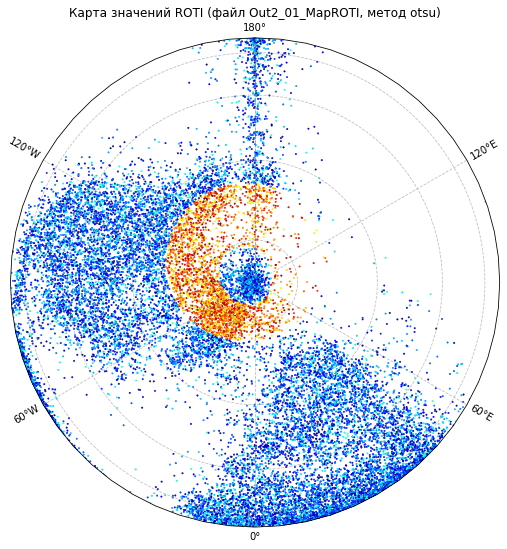

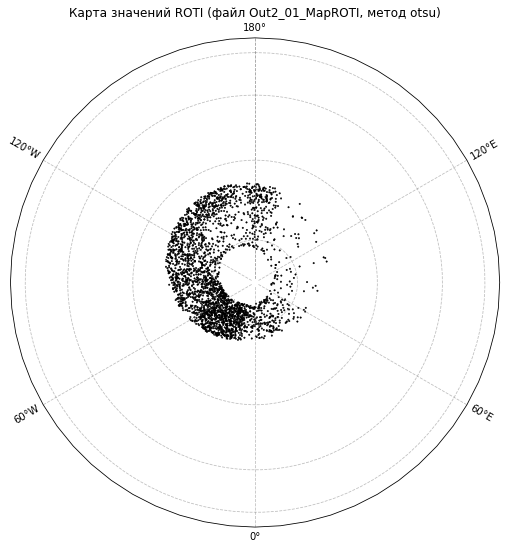

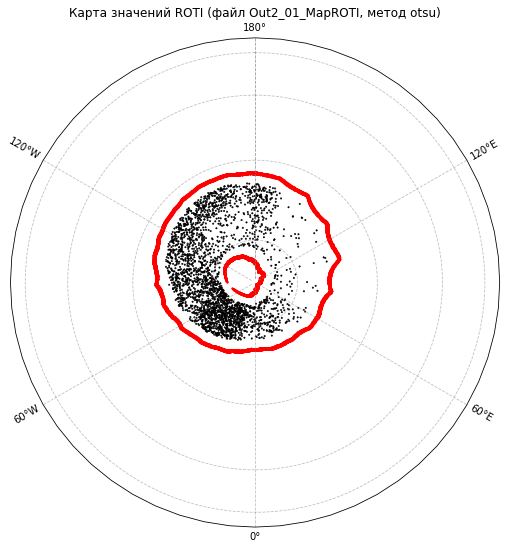

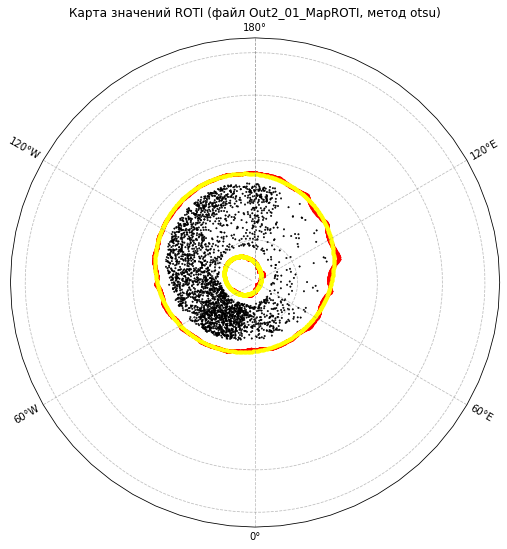

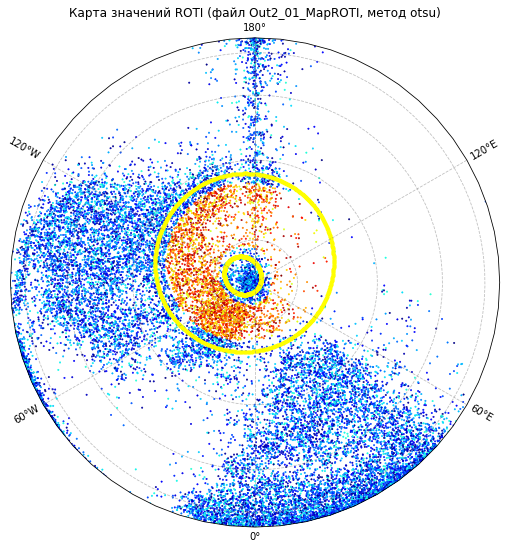

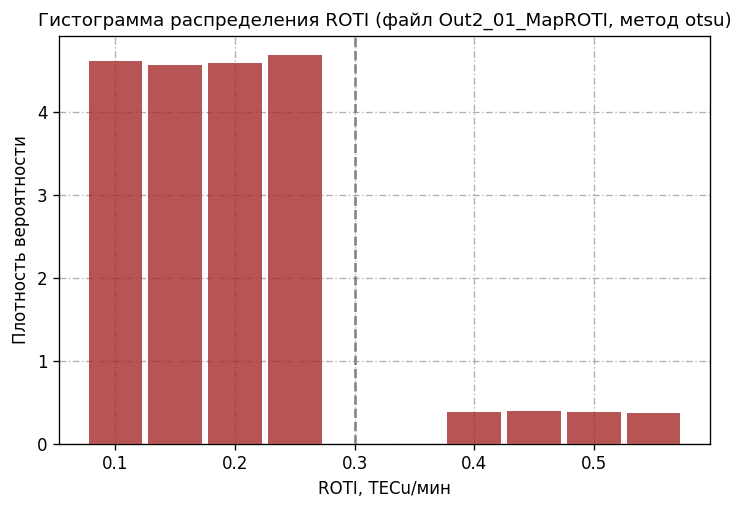

Время: 156.3 с


In [16]:
start_time = time.time()

file_path = 'data/Synthetic_oval/Out2/01_MapROTI.dat'
#file_path = 'data/hdf5/out.h5'
method = 'otsu'

process_file(file_path, method)

stop_time = time.time()
print('Время: %.1f с' % (stop_time - start_time))

In [ ]:
#file_path = 'data/Synthetic_oval/Out2/01_MapROTI.dat'
#file_path = 'data/hdf5/roti_2022_091_-90_90_N_-180_180_E_f157.h5'

hour_minute_second = '00:30:00'

file_paths = gl.glob('data/Synthetic_oval/*/*_MapROTI.dat')

file_paths.sort()

for file_path in file_paths:
    for method in ['kmeans', 'otsu', 'median', 'quantile']:
        print(method)
        try:
            process_file(file_path, method, hour_minute_second=hour_minute_second)
        except:
            continue

### Анализ данных

In [5]:
oval_center_lat = 86.0
oval_center_lon = -147.0
oval_radius = 2200.0

df = pd.read_csv('parameters_for_model_data_4.csv')

df['oval_center_lat'] = oval_center_lat
df['oval_center_lon'] = oval_center_lon
df['oval_radius'] = oval_radius

df['inner_center_diff'] = df.apply(lambda x: distance_geopy(x['inner_ellipse_center_lat'], x['inner_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)
df['outer_center_diff'] = df.apply(lambda x: distance_geopy(x['outer_ellipse_center_lat'], x['outer_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)

df['inner_center_diff_haversine'] = df.apply(lambda x: distance_haversine(x['inner_ellipse_center_lat'], x['inner_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)
df['outer_center_diff_haversine'] = df.apply(lambda x: distance_haversine(x['outer_ellipse_center_lat'], x['outer_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)

df['outer_width_diff']  = np.abs(df['outer_ellipse_width'] - df['oval_radius'])
df['outer_height_diff'] = np.abs(df['outer_ellipse_height'] - df['oval_radius'])

df

,file_name,method,inner_ellipse_center_lat,inner_ellipse_center_lon,inner_ellipse_width,inner_ellipse_height,inner_ellipse_angle,outer_ellipse_center_lat,outer_ellipse_center_lon,outer_ellipse_width,...,distance_max,oval_center_lat,oval_center_lon,oval_radius,inner_center_diff,outer_center_diff,inner_center_diff_haversine,outer_center_diff_haversine,outer_width_diff,outer_height_diff
0,Out1_01_MapROTI,kmeans,87.532828,-130.369710,668,784,35.7,84.847733,-160.542588,2357,...,1910,86.0,-147.0,2200.0,198.996107,175.582020,207.448250,183.042904,157.0,22.0
1,Out1_01_MapROTI,otsu,87.537255,-130.438169,670,785,35.8,84.842574,-160.376591,2353,...,1903,86.0,-147.0,2200.0,199.165147,175.058693,207.624477,182.497413,153.0,21.0
2,Out1_01_MapROTI,median,83.946867,-70.115324,9756,10524,12.2,85.197833,-69.703787,10782,...,2040,86.0,-147.0,2200.0,720.344137,617.612981,750.943721,643.841334,8582.0,7768.0
3,Out1_01_MapROTI,quantile,84.491501,-145.427277,1558,1458,-55.4,84.760629,-150.023459,1700,...,337,86.0,-147.0,2200.0,169.090570,141.020271,176.279998,147.015420,500.0,603.0
4,Out1_02_MapROTI,kmeans,87.526168,-129.962696,666,777,36.4,84.826643,-159.707654,2341,...,1901,86.0,-147.0,2200.0,199.700957,172.609851,208.182997,179.944785,141.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Out5_18_MapROTI,quantile,85.074027,-153.584110,1393,1515,-19.2,84.661836,-156.817780,1595,...,376,86.0,-147.0,2200.0,118.031634,173.556988,123.047946,180.933825,605.0,454.0
376,Out5_19_MapROTI,kmeans,87.940717,-89.427765,9856,10460,-66.8,87.663024,-154.580569,10586,...,1257,86.0,-147.0,2200.0,377.143250,191.147244,393.157833,199.266663,8386.0,8038.0
377,Out5_19_MapROTI,otsu,89.297302,-0.369757,10319,9538,27.4,87.472874,179.987015,10366,...,1634,86.0,-147.0,2200.0,514.128940,260.277018,535.959084,271.330104,8166.0,7886.0
378,Out5_19_MapROTI,median,87.819042,-88.725853,9895,10488,-66.6,87.756303,-151.276424,10631,...,1389,86.0,-147.0,2200.0,380.016680,197.743687,396.153136,206.143307,8431.0,8065.0


Расстояния между границами овала

In [7]:
df[['file_name', 'method', 'distance_min', 'distance_mean', 'distance_modal', 'distance_max']]

,file_name,method,distance_min,distance_mean,distance_modal,distance_max
0,Out1_01_MapROTI,kmeans,1069,1537,1676,1831
1,Out1_01_MapROTI,otsu,1064,1533,1667,1824
2,Out1_01_MapROTI,median,1560,1724,1659,1950
3,Out1_01_MapROTI,quantile,209,268,323,323
4,Out1_02_MapROTI,kmeans,1070,1534,1647,1822
...,...,...,...,...,...,...
375,Out5_18_MapROTI,quantile,234,297,318,360
376,Out5_19_MapROTI,kmeans,328,813,851,1196
377,Out5_19_MapROTI,otsu,635,1133,1086,1559
378,Out5_19_MapROTI,median,496,994,1065,1323


Ошибки определения центра овала

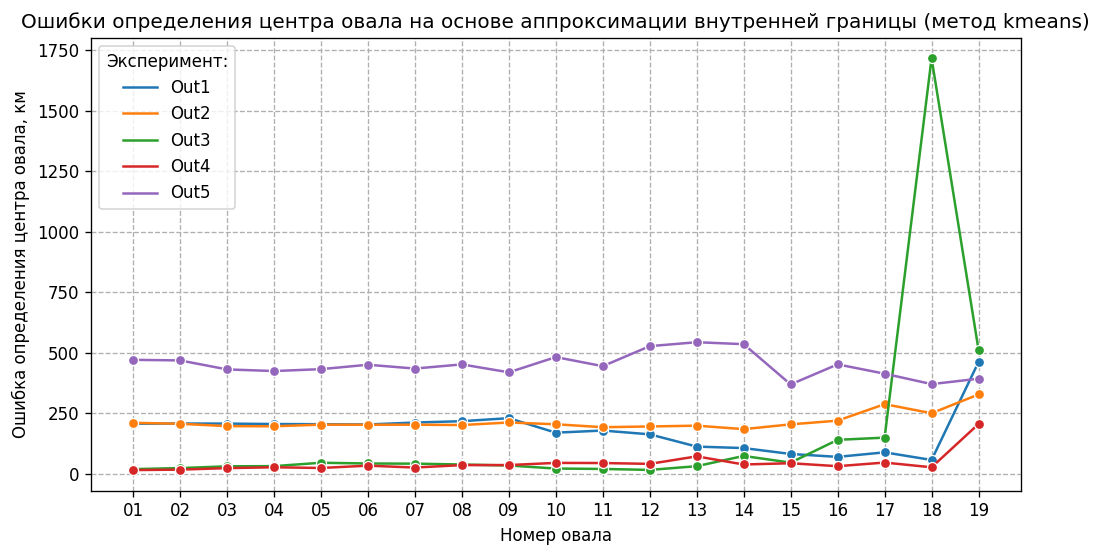

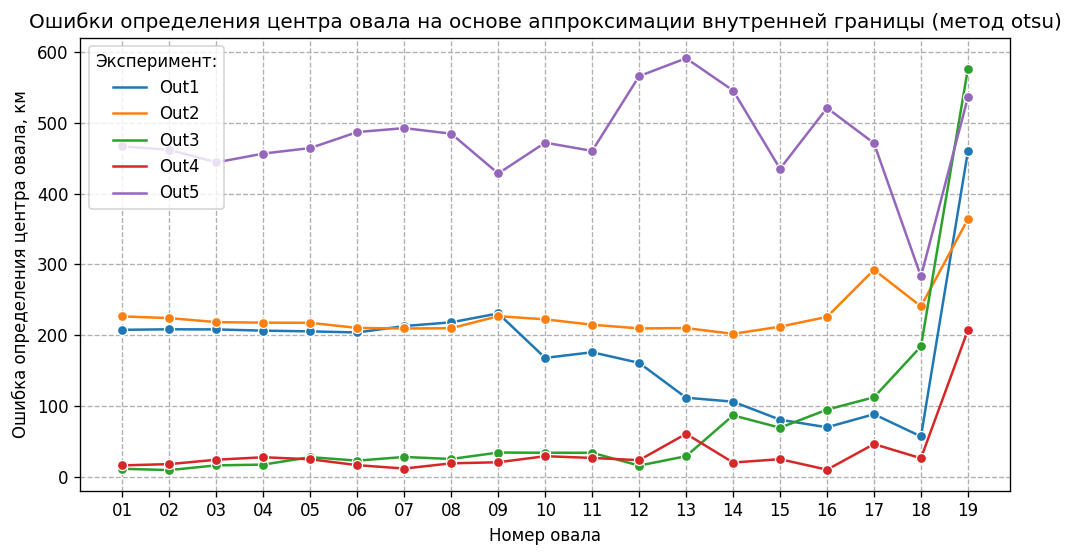

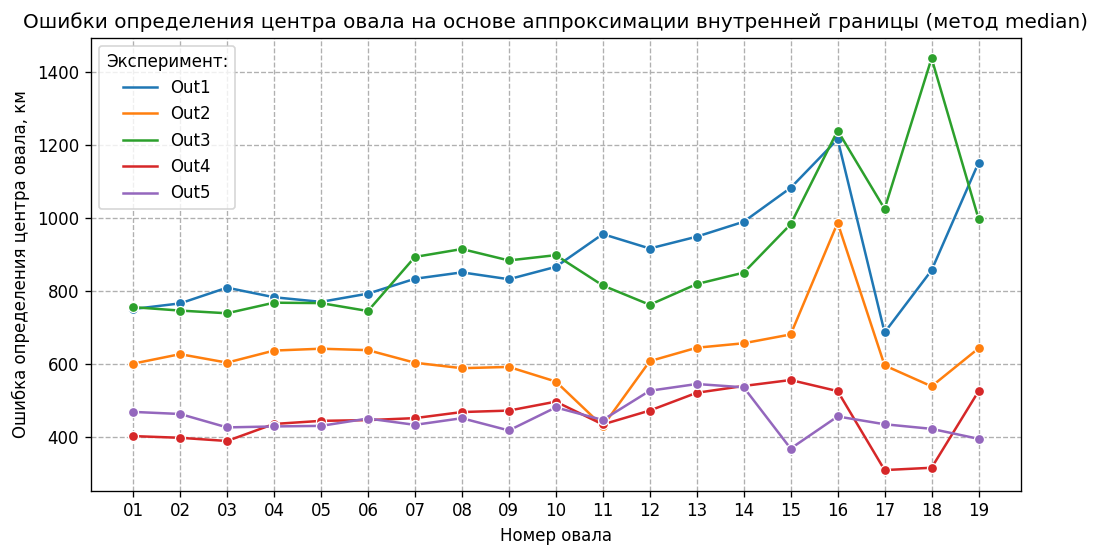

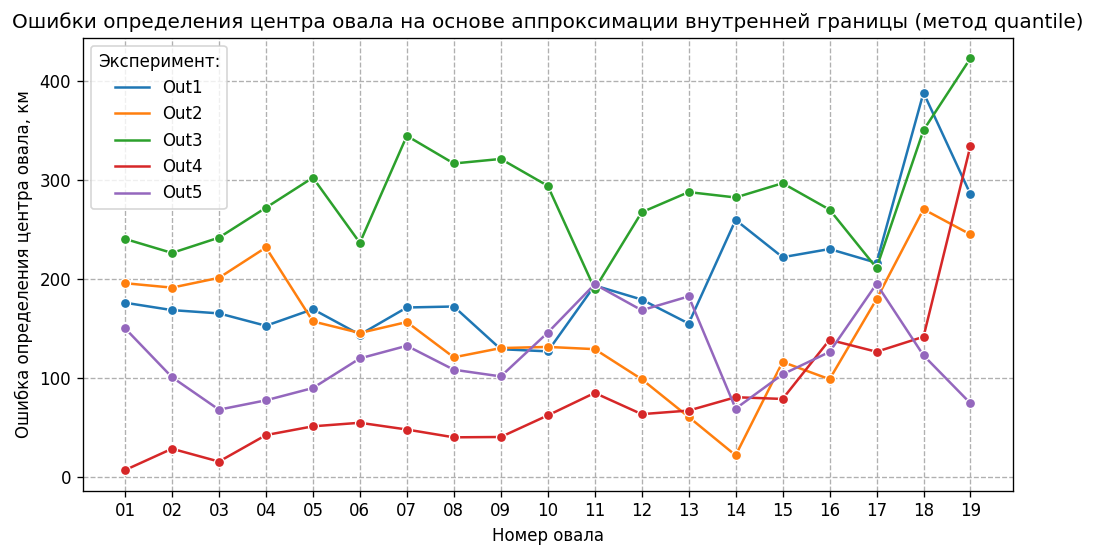

Таблица 1 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внутренней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,179,178,887,195
Out2,216,229,625,152
Out3,160,75,897,283
Out4,45,34,454,80
Out5,448,477,453,123


Таблица 2 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внутренней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,199,198,898,205
Out2,219,232,633,164
Out3,415,147,914,288
Out4,60,55,459,106
Out5,451,481,455,129


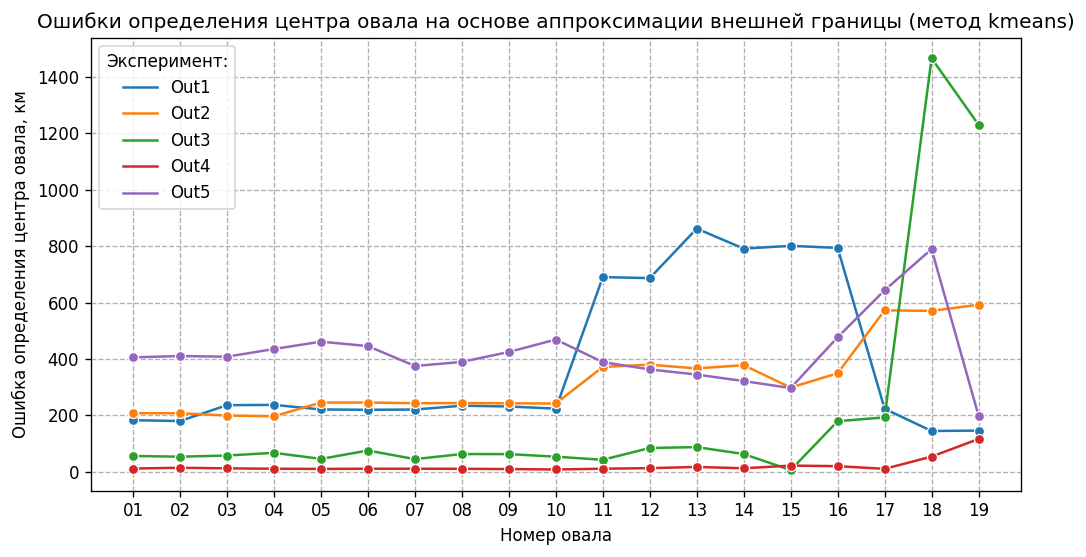

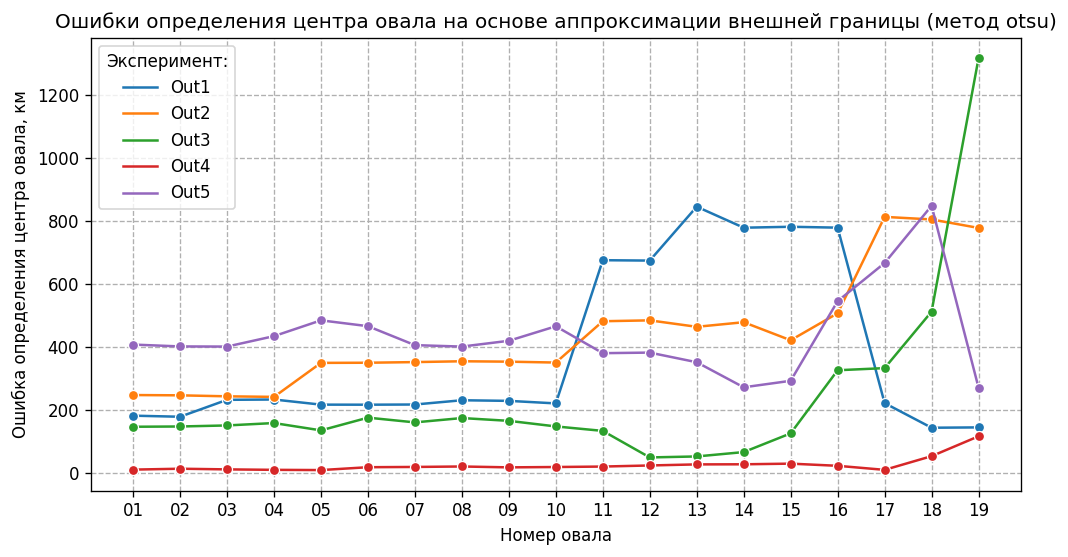

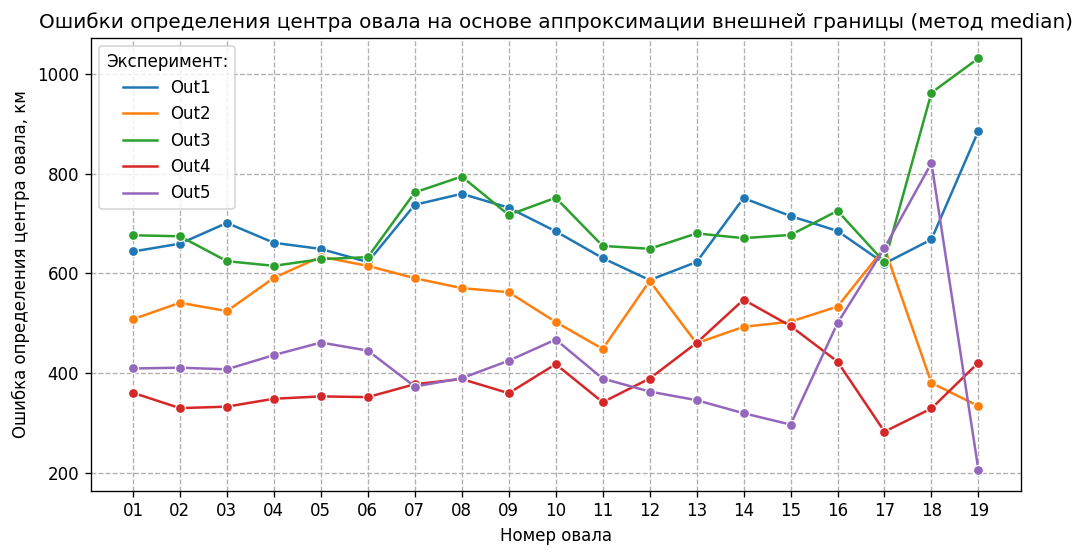

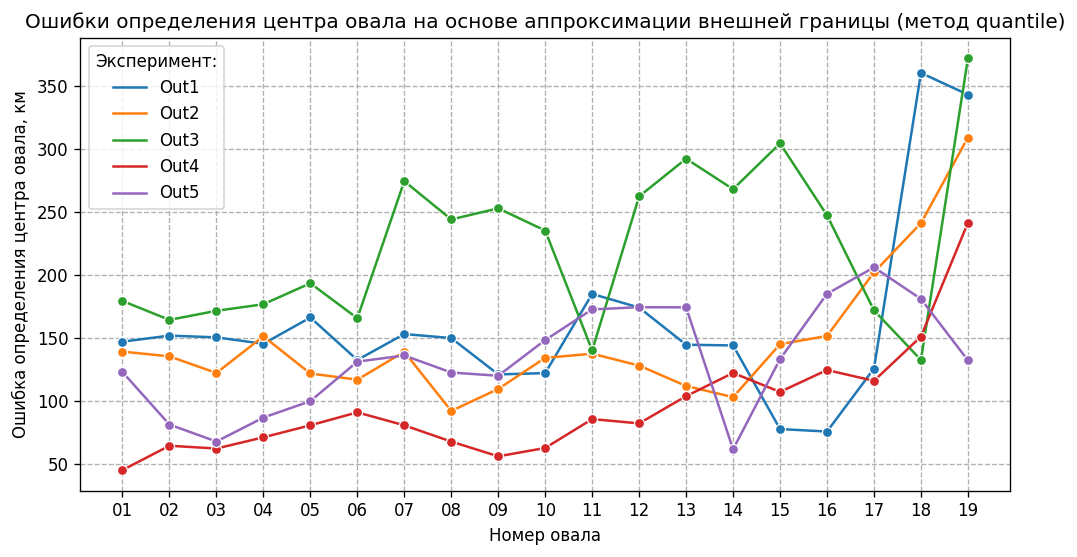

Таблица 3 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внешней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,386,379,685,162
Out2,324,438,528,147
Out3,207,236,713,224
Out4,20,26,385,95
Out5,424,437,428,133


Таблица 4 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внешней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,468,459,688,176
Out2,348,473,534,155
Out3,447,363,721,232
Out4,32,35,390,105
Out5,441,456,446,140


In [6]:
methods = [' kmeans', ' otsu', ' median', ' quantile']

inner_center_diff = df.pivot_table('inner_center_diff_haversine', index='file_name', columns='method', aggfunc='mean').reset_index()
# название эксперимента (Out1, Out2, Out3, Out4, Out5)
inner_center_diff['experiment_id'] = inner_center_diff['file_name'].str.split('_').str[0]
# номер овала (01, 02, 03, 04, ... 18, 19)
inner_center_diff['oval_id'] = inner_center_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=inner_center_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения центра овала на основе аппроксимации внутренней границы (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения центра овала, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-inner-center-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 1 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внутренней границы')
display(inner_center_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 2 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внутренней границы')
display(inner_center_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))

# сводная таблица с ошибками определения центра овала
outer_center_diff = df.pivot_table('outer_center_diff_haversine', index='file_name', columns='method', aggfunc='mean').reset_index()
outer_center_diff['experiment_id'] = outer_center_diff['file_name'].str.split('_').str[0]
outer_center_diff['oval_id'] = outer_center_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=outer_center_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения центра овала на основе аппроксимации внешней границы (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения центра овала, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-outer-center-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 3 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внешней границы')
display(outer_center_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 4 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внешней границы')
display(outer_center_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))

Отображаем ошибки определения радиуса овала

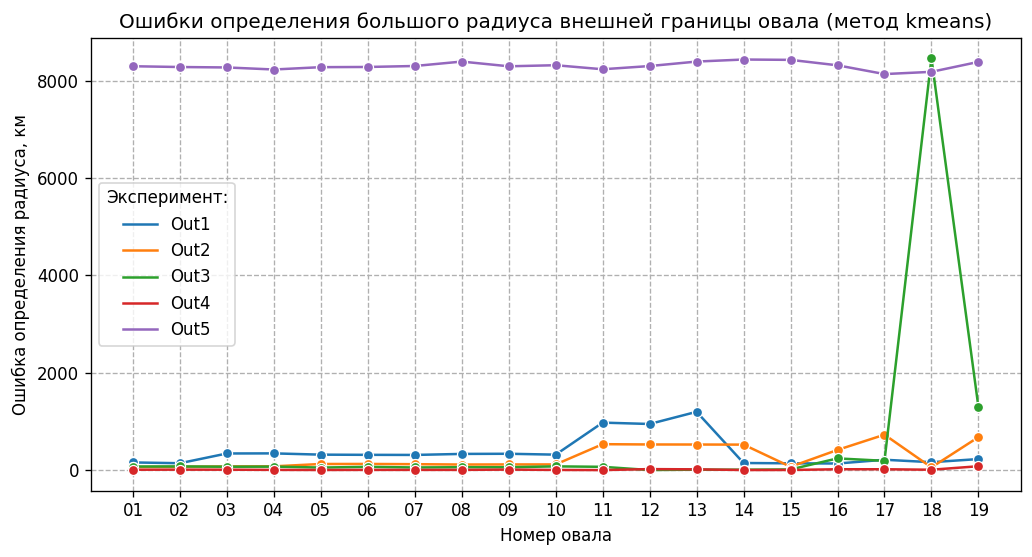

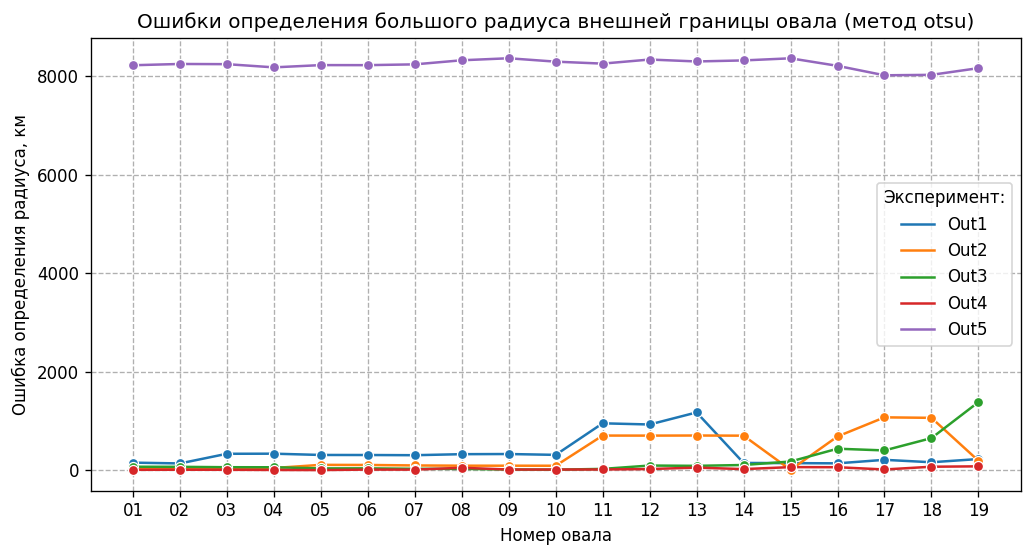

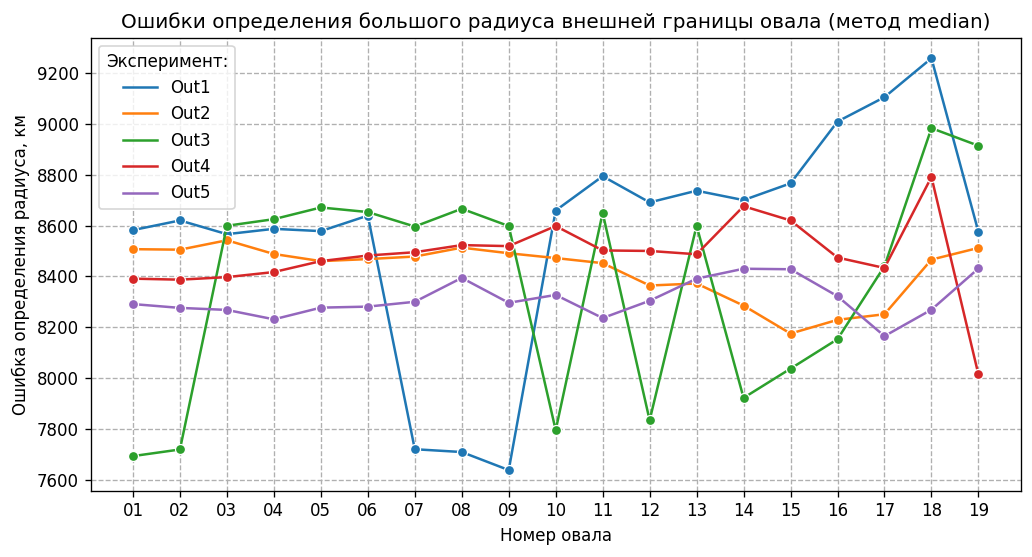

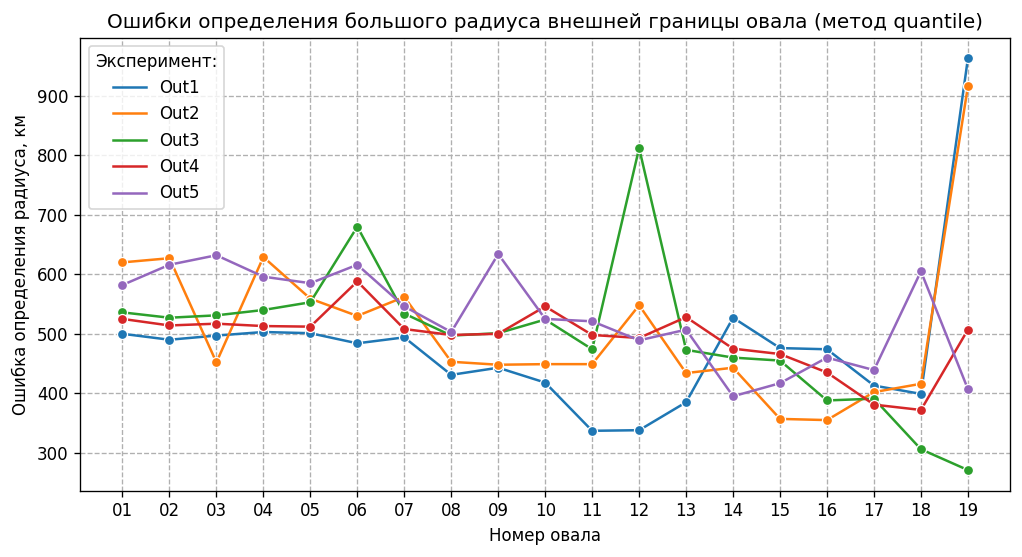

Таблица 5 - Абсолютные ошибки определения большого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,371,364,8575,478
Out2,266,346,8423,508
Out3,576,198,8376,498
Out4,11,28,8482,493
Out5,8303,8243,8311,530


Таблица 6 - Среднеквадратические ошибки определения большого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,479,469,8586,494
Out2,354,504,8423,524
Out3,1966,381,8386,511
Out4,20,37,8484,496
Out5,8304,8243,8312,536


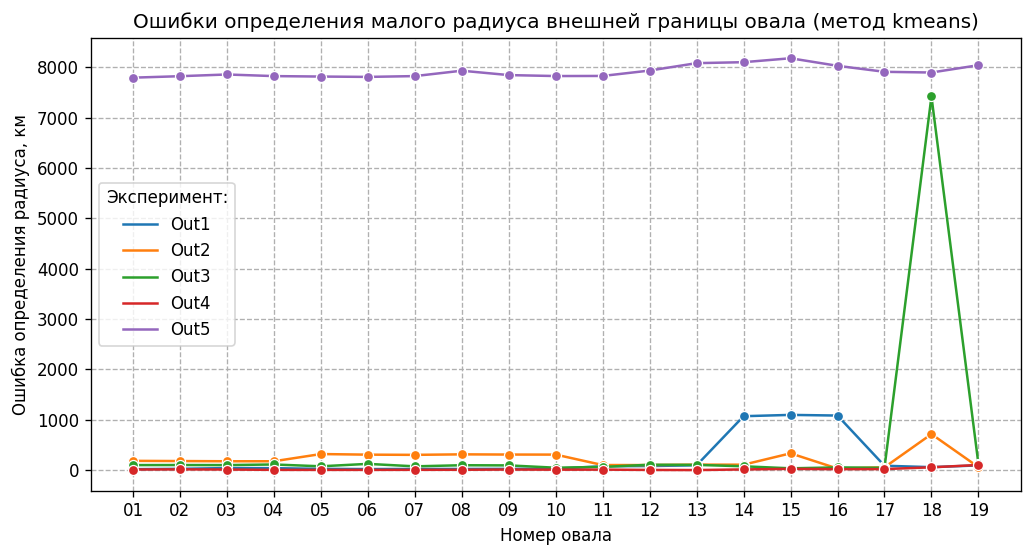

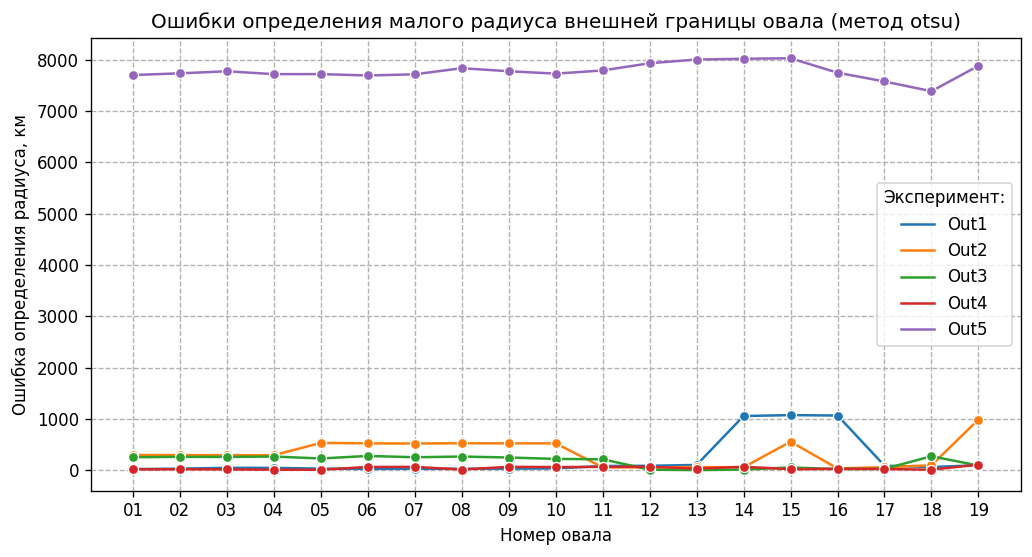

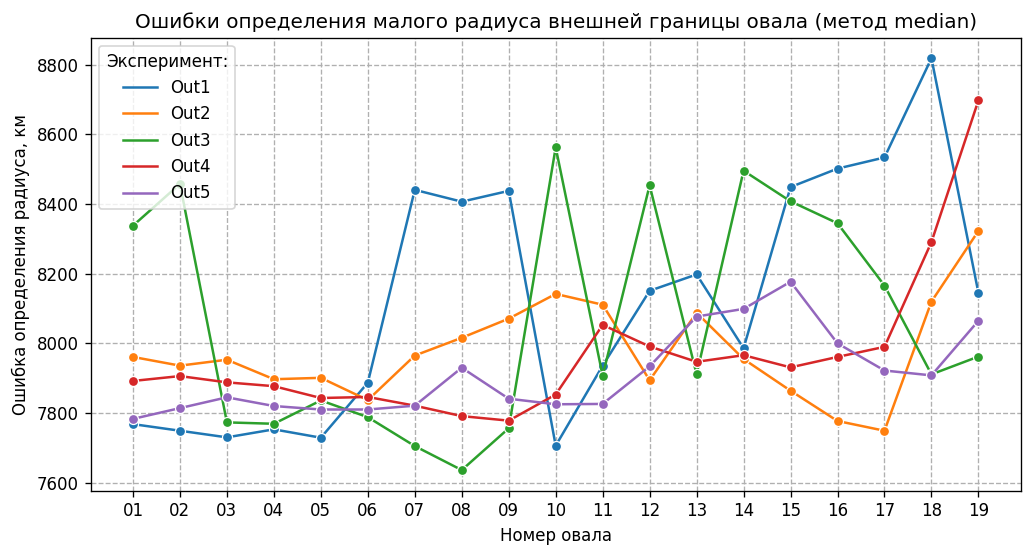

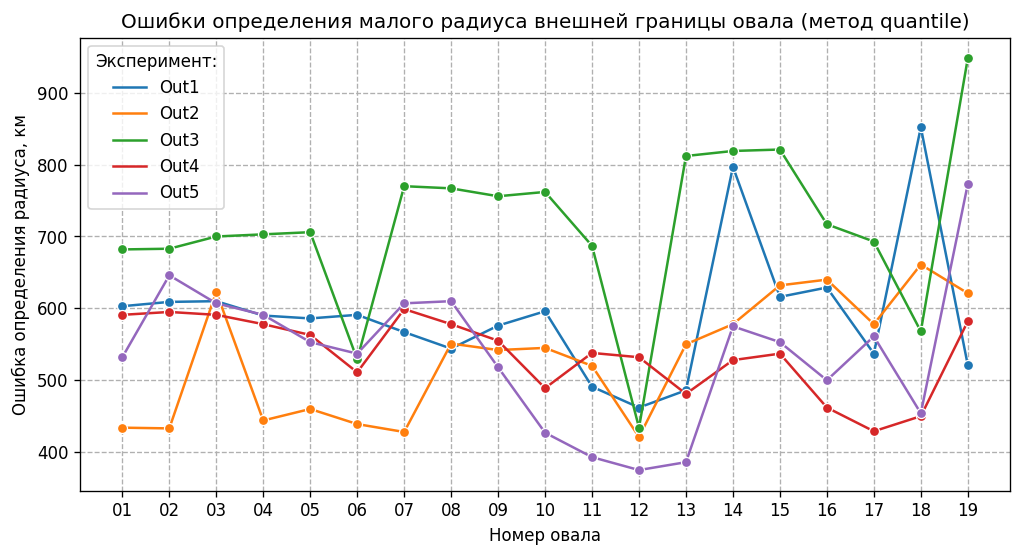

Таблица 7 - Абсолютные ошибки определения малого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,214,211,8123,593
Out2,223,329,7977,532
Out3,474,169,8062,714
Out4,21,38,7964,536
Out5,7910,7781,7911,537


Таблица 8 - Среднеквадратические ошибки определения малого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,435,426,8130,600
Out2,272,416,7978,538
Out3,1704,201,8068,722
Out4,31,48,7967,539
Out5,7911,7783,7912,545


In [7]:
# ошибки определения большого радиуса внешней границы овала
outer_width_diff = df.pivot_table('outer_width_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
# ошибки определения центра овала
outer_width_diff = df.pivot_table('outer_width_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
outer_width_diff['experiment_id'] = outer_width_diff['file_name'].str.split('_').str[0]
outer_width_diff['oval_id'] = outer_width_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=outer_width_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения большого радиуса внешней границы овала (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения радиуса, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-outer-width-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 5 - Абсолютные ошибки определения большого радиуса внешней границы овала')
display(outer_width_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 6 - Среднеквадратические ошибки определения большого радиуса внешней границы овала')
display(outer_width_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))


# ошибки определения малого радиуса внешней границы овала
outer_height_diff = df.pivot_table('outer_height_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
# ошибки определения центра овала
outer_height_diff = df.pivot_table('outer_height_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
outer_height_diff['experiment_id'] = outer_height_diff['file_name'].str.split('_').str[0]
outer_height_diff['oval_id'] = outer_height_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=outer_height_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения малого радиуса внешней границы овала (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения радиуса, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-outer-height-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 7 - Абсолютные ошибки определения малого радиуса внешней границы овала')
display(outer_height_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 8 - Среднеквадратические ошибки определения малого радиуса внешней границы овала')
display(outer_height_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))